In [1]:
%matplotlib inline

import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import bayes_net_utils as bn

from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score

plt.style.use('ggplot')

# Introduction

Notebook for carrying out visual and statistical comparison of observed and predicted seasonal water chemistry and ecology in Vanemfjorden. Takes predictions produced by notebook Predict_with_BN.ipynb and either compares predictions produced using different kinds of met data, or compares predictions to observations from the lake. 

In [2]:
# Paths to files and folders
obs_fpath = '../Data/DataMatrices/Seasonal_BN_obs/seasonal_obs_GBN_1981-2019.csv'
sim_era5_fpath = '../Data/Predictions/Historic/GBN_prediction_era5_1981-2018.csv'
sim_metno_fpath = '../Data/Predictions/Historic/GBN_prediction_metno_1981-2018.csv'
sim_metno_biasadj_fpath = '../Data/Predictions/Historic/GBN_prediction_metno_1981-2018_biasadjusted-cyano_v2.csv'
sim_nomet_ba_fpath = '../Data/Predictions/Historic/GBN_prediction_nomet_1981-2018_biasadjusted-cyano_v2.csv'
sim_nomet_fpath = '../Data/Predictions/Historic/GBN_prediction_nomet_1981-2018.csv'
sim_naive_fpath = '../Data/Predictions/Historic/Prediction_naive_1981-2019.csv'

out_folder = '../Hindcast_stats_plots'

var_list = ['TP','chla','colour','cyano']

# Read in data and reformat

## Observations

In [3]:
# Read in the observations
obs_wide = pd.read_csv(obs_fpath)

# Reformat obs to long format, same as the others
obs = pd.melt(obs_wide, id_vars=['year'], value_vars=var_list,
         var_name='node', value_name='obs')

obs.tail()

,year,node,obs
151,2015,cyano,0.233
152,2016,cyano,0.166
153,2017,cyano,0.258
154,2018,cyano,0.614
155,2019,cyano,0.592


In [4]:
# Classify the observations

# Dictionary of thresholds to use. N.B. Also defined in bayes_net_utils.R (as boundaries_list)
boundaries_dict = {'TP': 29.5,     # Middle of 'Moderate' class
                   'chla': 20.0,   # M-P boundary. WFD boundaries: [10.5, 20.0]. Only 6 observed points under 10.5 so merge G & M
                   'colour': 48.0, # 66th percentile (i.e. upper tercile). No management implications
                   'cyano': 1.0    # M-P boundary is 2.0, but there were only 2 values in this class. Plenty above 2 tho
                  }

obs_disc = obs.copy()
obs_disc['obs'] = obs[['node','obs']].apply(lambda x: bn.discretize([boundaries_dict[x.node]], x.obs), axis=1)
obs_disc.head()

,year,node,obs
0,1981,TP,0.0
1,1982,TP,0.0
2,1983,TP,1.0
3,1984,TP,0.0
4,1985,TP,1.0


## Seasonal naive prediction
i.e. prediction for the current season is the prediction for the previous (corresponding) season

In [5]:
# sim_naive_wide = pd.read_csv(sim_naive_fpath)

# # Reformat obs to long format, same as the others
# sim_naive = pd.melt(sim_naive_wide, id_vars=['year'], value_vars=var_list,
#             var_name='node', value_name='sim_naive')

# sim_naive_disc = sim_naive.copy()
# sim_naive_disc['sim_naive'] = sim_naive_disc[['node','sim_naive']].apply(lambda x: bn.discretize([boundaries_dict[x.node]], x.sim_naive), axis=1)
# sim_naive_disc.head(2)

sim_naive_raw = pd.read_csv(sim_naive_fpath)

# Pick out just the expected value
sim_naive = sim_naive_raw[['year','node','expected_value']]
sim_naive.columns = ['year','node','sim_naive'] # Rename columns
display(sim_naive.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_naive_disc = sim_naive_raw[['year','node','WFD_class']]
sim_naive_disc.columns = ['year','node','sim_naive']
display(sim_naive_disc.head(2))

,year,node,sim_naive
0,1981,TP,43.573016
1,1982,TP,28.833333


,year,node,sim_naive
0,1981,TP,1.0
1,1982,TP,0.0


## BN predictions

In [6]:
# Read in predictions from BN with met nodes, met.no data
sim_metno_raw = pd.read_csv(sim_metno_fpath)

# Pick out just the expected value
sim_metno = sim_metno_raw[['year','node','expected_value']]
sim_metno.columns = ['year','node','sim_metno'] # Rename columns
display(sim_metno.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_metno_class = sim_metno_raw[['year','node','WFD_class']]
sim_metno_class.columns = ['year','node','sim_metno']
display(sim_metno_class.head(2))

,year,node,sim_metno
0,1981,chla,20.0
1,1981,colour,28.0


,year,node,sim_metno
0,1981,chla,1
1,1981,colour,0


In [7]:
# BN predictions, met nodes, bias-adjusted cyano
sim_metno_ba_raw = pd.read_csv(sim_metno_biasadj_fpath)

# Pick out just the expected value
sim_metno_ba = sim_metno_ba_raw[['year', 'node', 'expected_value']]
sim_metno_ba.columns = ['year', 'node', 'sim_metno_ba'] # Rename columns
display(sim_metno_ba.head(2))

# Discretized df, including the class and the predicted probability of being in the class
sim_metno_ba_class = sim_metno_ba_raw[['year', 'node', 'WFD_class']]
sim_metno_ba_class.columns = ['year', 'node', 'sim_metno_ba']
display(sim_metno_class.head(2))

,year,node,sim_metno_ba
0,1981,chla,20.0
1,1981,colour,28.0


,year,node,sim_metno
0,1981,chla,1
1,1981,colour,0


In [8]:
# BN predictions, no met nodes
sim_nomet_raw = pd.read_csv(sim_nomet_fpath)

# Pick out just the expected value
sim_nomet = sim_nomet_raw[['year','node','expected_value']]
sim_nomet.columns = ['year','node','sim_nomet'] # Rename columns
display(sim_nomet.head(2))

# Discretized df, including the class prediction
sim_nomet_class = sim_nomet_raw[['year','node','WFD_class']]
sim_nomet_class.columns = ['year','node','sim_nomet']
display(sim_nomet_class.head(2))

,year,node,sim_nomet
0,1981,chla,19.6
1,1981,colour,27.1


,year,node,sim_nomet
0,1981,chla,0
1,1981,colour,0


In [9]:
# BN predictions, no met nodes, bias-adjusted cyanobacteria back transform
sim_nomet_ba_raw = pd.read_csv(sim_nomet_ba_fpath)

# Pick out just the expected value
sim_nomet_ba = sim_nomet_ba_raw[['year','node','expected_value']]
sim_nomet_ba.columns = ['year','node','sim_nomet_ba'] # Rename columns
display(sim_nomet_ba.head(2))

# Discretized df, including the class prediction
sim_nomet_ba_class = sim_nomet_ba_raw[['year','node','WFD_class']]
sim_nomet_ba_class.columns = ['year','node','sim_nomet_ba']
display(sim_nomet_ba_class.head(2))

,year,node,sim_nomet_ba
0,1981,chla,19.6
1,1981,colour,27.1


,year,node,sim_nomet_ba
0,1981,chla,0
1,1981,colour,0


## Merge observations and predictions from all kinds of model

In [10]:
def merge_model_predictions(df_list):
    df = df_list[0].copy().set_index(['year','node'])
    for i, new_df in enumerate(df_list):
        new_df = new_df.set_index(['year','node'])
        if i>=1:
            df = df.join(new_df)
    df = df.reset_index()
    return df

In [11]:
# Make a dataframe of continuous data (expected values)
df_li = [obs,
         sim_metno,
         sim_metno_ba,
         sim_nomet,
         sim_nomet_ba,
         sim_naive]

df_cont = merge_model_predictions(df_li)

df_cont.tail()

,year,node,obs,sim_metno,sim_metno_ba,sim_nomet,sim_nomet_ba,sim_naive
151,2015,cyano,0.233,0.316,0.614,0.411,0.778,0.283
152,2016,cyano,0.166,0.446,0.838,0.473,0.885,0.233
153,2017,cyano,0.258,0.223,0.449,0.226,0.455,0.166
154,2018,cyano,0.614,0.338,0.653,0.405,0.768,0.258
155,2019,cyano,0.592,NaN,NaN,NaN,NaN,0.614


In [12]:
# Merge discretized timeseries into discretized dfs

df_class_list = [obs_disc,
                 sim_naive_disc,
                 sim_metno_class[['year', 'node', 'sim_metno']],
                 sim_metno_ba_class[['year', 'node', 'sim_metno_ba']],
                 sim_nomet_class[['year', 'node', 'sim_nomet']],
                 sim_nomet_ba_class[['year', 'node', 'sim_nomet_ba']]
                ]

df_classes = merge_model_predictions(df_class_list)

df_classes.tail()

,year,node,obs,sim_naive,sim_metno,sim_metno_ba,sim_nomet,sim_nomet_ba
151,2015,cyano,0.0,0.0,0.0,0.0,0.0,0.0
152,2016,cyano,0.0,0.0,0.0,0.0,0.0,0.0
153,2017,cyano,0.0,0.0,0.0,0.0,0.0,0.0
154,2018,cyano,0.0,0.0,0.0,0.0,0.0,0.0
155,2019,cyano,0.0,0.0,NaN,NaN,NaN,NaN


# Plot time series

In [13]:
label_dict = {'obs': 'Observed',
              'sim_metno': 'BN, with met',
              'sim_metno_ba': 'BN, met, bias-adjusted cyano',
              'sim_nomet': 'BN, no met',
              'sim_nomet_ba': 'BN, no met, bias-adjusted cyano',
              'sim_naive': 'Seasonal naive'}

colour_dict = {'obs': 'k',
               'sim_metno': 'b',
               'sim_metno_ba': 'g',
               'sim_naive': '0.4',
               'sim_nomet': 'r',
               'sim_nomet_ba': 'y'}

ylabel_dict = {'TP': 'TP (μg/l)',
               'chla': 'Chl-a (mg/l)',
               'colour': 'Colour (mg Pt/l)',
               'cyano': 'Cyanobacteria (mg/l)'}

## First, look at the difference bias-adjusted back-transformation of the the cyanobacteria makes

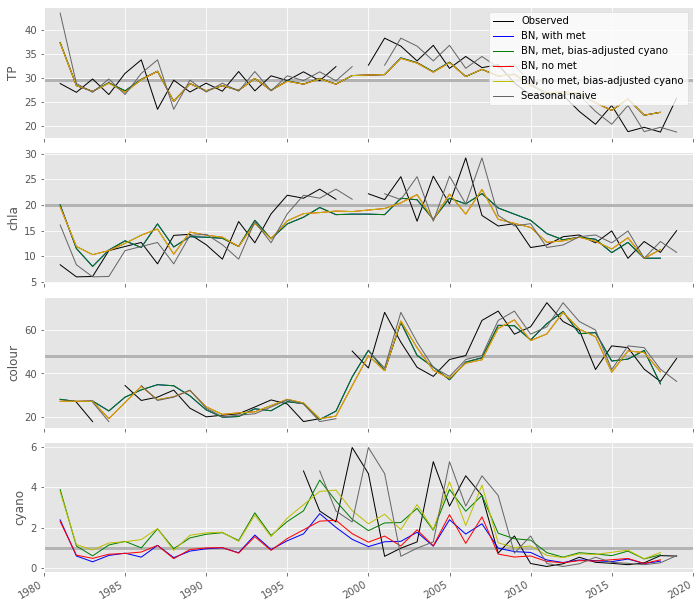

In [14]:
# Setup plot
fig, axes = plt.subplots(
    nrows=len(var_list),
    ncols=1,
    figsize=(10, 10),
    sharex=True,
)

# Loop over vars
for idx, var in enumerate(var_list):

    # Add WFD boundaries
    axes[idx].axhline(y=boundaries_dict[var], color="0.7", lw=3)

    # Plot observations and predictions
    for col in label_dict.keys():
        #         if var == 'TP' and col not in ['obs', 'sim_naive']:
        #             pass
        #         else:
        var_series = df_cont.loc[df_cont["node"] == var, [col, "year"]]
        var_series = var_series.set_index("year")

        axes[idx].plot(
            var_series.index,
            var_series.values,
            color=colour_dict[col],
            lw=1,
            label=label_dict[col],
        )

    # Tidy
    axes[idx].set_ylabel(var)
    axes[idx].set_xlim(xmin=1980, xmax=2020)

    if idx == 0:
        axes[idx].legend(facecolor="white")
#     axes[idx].legend(bbox_to_anchor=(1.35, 1))

plt.tight_layout()
fig.autofmt_xdate()
# plt.savefig(os.path.join(out_folder,'Timeseries_gof','timeseries_gof_metno_chla.png'), dpi=300)

## Plot for the paper

Just the bias adjusted back transformed cyanobacteria this time

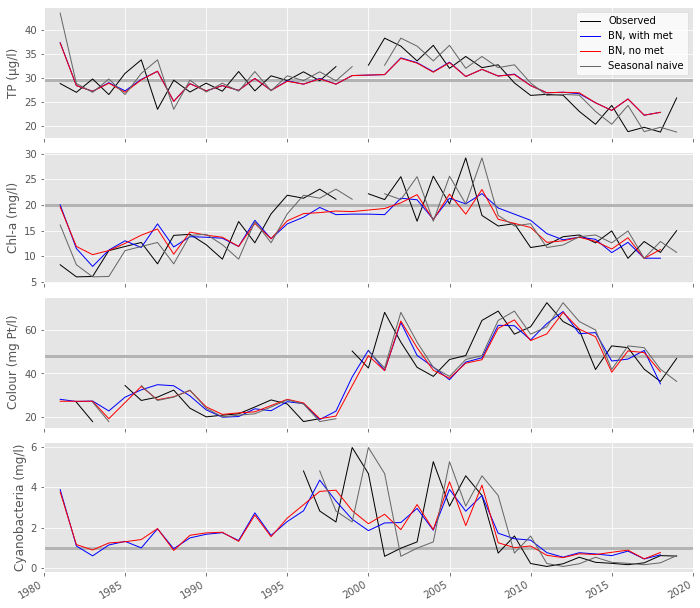

In [18]:
# Setup plot
fig, axes = plt.subplots(nrows=len(var_list),
                         ncols=1,
                         figsize=(10, 10),
                         sharex=True,
                        )

label_dict = {'obs': 'Observed',
              'sim_metno_ba': 'BN, with met',
              'sim_nomet_ba': 'BN, no met',
              'sim_naive': 'Seasonal naive'}

colour_dict = {'obs': 'k',
               'sim_metno_ba': 'b',
               'sim_naive': '0.4',
               'sim_nomet_ba': 'r'}

# Loop over vars
for idx, var in enumerate(var_list):

    # Add WFD boundaries
    axes[idx].axhline(y=boundaries_dict[var], color='0.7', lw=3)

    # Plot observations and predictions
    for col in label_dict.keys():
        var_series = df_cont.loc[df_cont['node'] == var, [col, 'year']]
        var_series = var_series.set_index('year')

        axes[idx].plot(var_series.index,
                       var_series.values,
                       color=colour_dict[col],
                       lw=1,
                       label=label_dict[col]
                      )

    # Tidy
    axes[idx].set_ylabel(ylabel_dict[var])
    axes[idx].set_xlim(xmin=1980, xmax=2020)

    if idx == 0:
        axes[idx].legend(facecolor='white')
#     axes[idx].legend(bbox_to_anchor=(1.35, 1))

plt.tight_layout()
fig.autofmt_xdate()
plt.savefig(os.path.join(out_folder,'Timeseries_gof','timeseries_gof_metno_bias-adj-cyano.png'), dpi=300)

# Goodness of fit statistics: simulated vs observed

## Define functions to calculate continuous and discrete GoF stats

In [16]:
def gof_stats(df, obs_col, sim_cols_of_interest, st_yr, end_yr=2018):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest
    Input:
        df: with columns 'year', 'node' (variable), 'obs', predicted values
        obs_col: string, name of column containing observations
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats    
    """
    gof_df_dict = {} # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df['node']==var]
        df_var = df_var.drop('node', axis=1).set_index('year')
        df_var = df_var.loc[st_yr:end_yr+1,:]  

        cc_li = []
        cc_sp_li = []
        mae_li = []  # mean absolute error
        rmse_li = []
        bias_li = []
        mape_li = []  # mean absolute % error

        for col in sim_cols_of_interest:

            df_test = df_var[[obs_col, col]].dropna()

            errors = df_test[col] - df_test[obs_col]

            cc = df_test[obs_col].corr(df_test[col], method='pearson')
            cc_sp = df_test[obs_col].corr(df_test[col], method='spearman')
            mae = np.mean(np.abs(errors))
            rmse = np.sqrt(np.mean(((errors) ** 2)))
            bias = np.mean(errors)
            mape = np.mean(100*(errors/df_test[obs_col]))

            cc_li.append(cc)
            cc_sp_li.append(cc_sp)
            mae_li.append(mae)
            rmse_li.append(rmse)
            bias_li.append(bias)
            mape_li.append(mape)

        gof_df = pd.DataFrame(list(zip(cc_li, cc_sp_li, mae_li, rmse_li, bias_li, mape_li)),
                              columns = ['pearsons_cc','spearman_cc','mae','rmse','bias','mape'],
                              index = sim_cols_of_interest)

        gof_df_dict[var] = gof_df

    gof_df = pd.concat(gof_df_dict.values(), keys=gof_df_dict.keys())

    return gof_df

In [17]:
def gof_stats_classified_data(df, obs_col, sim_cols_of_interest, st_yr, end_yr=2018):
    """
    Calculate goodness-of-fit statistics for columns of interest, over a time period of interest.
    See https://towardsdatascience.com/machine-learning-an-error-by-any-other-name-a7760a702c4d for a description of stats calculated,
    as well as the sklearn documentation

    Input:
        df: with columns 'year', 'node' (variable), observed and predicted values
        obs_col: string, name of column containing observations
        sim_cols_of_interest: list of column names of interest containing predictions
        st_yr: start year, integer
        end_yr: end year, integer. Default 2019
    Output:
        df with GoF stats
    """

    gof_df_disc_dict = {}  # Key: var, returns df with GoF stats

    for var in var_list:

        df_var = df.loc[df['node'] == var]
        df_var = df_var.drop('node', axis=1).set_index('year')
        df_var = df_var.loc[st_yr:end_yr+1,:]

        mcc_li = []  # Matthews correlation coefficient
        roc_li = []  # ROC
        ce_li = []  # Classification error

        for col in sim_cols_of_interest:

            test_df = df_var[[obs_col, col]].dropna()

            mcc = matthews_corrcoef(test_df[obs_col].values, test_df[col].values)
            rocs = roc_auc_score(test_df[obs_col].values, test_df[col].values)
            ce = bn.classification_error(test_df[obs_col], test_df[col])

            mcc_li.append(mcc)
            roc_li.append(rocs)
            ce_li.append(ce)

        gof_df = pd.DataFrame(list(zip(mcc_li,
                                       roc_li,
                                      ce_li)),
                              columns = ['mathews_cc',
                                        'roc_auc_score',
                                        'classification_error'],
                              index = sim_cols_of_interest)

        gof_df_disc_dict[var] = gof_df

    gof_class_df = pd.concat(gof_df_disc_dict.values(), keys=gof_df_disc_dict.keys())

    return gof_class_df

## Simulated vs observations

In [30]:
df_classes.head()

,year,node,obs,sim_naive,sim_metno,sim_metno_ba,sim_nomet,sim_nomet_ba
0,1981,TP,0.0,1.0,1.0,1.0,1.0,1.0
1,1982,TP,0.0,0.0,0.0,0.0,0.0,0.0
2,1983,TP,1.0,0.0,0.0,0.0,0.0,0.0
3,1984,TP,0.0,1.0,0.0,0.0,0.0,0.0
4,1985,TP,1.0,0.0,0.0,0.0,0.0,0.0


In [18]:
obs_col = 'obs'
sim_cols = ['sim_naive', 'sim_metno', 'sim_metno_ba', 'sim_nomet', 'sim_nomet_ba']
st_yr = 1981

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(['var', 'model'])

gof_df.reset_index().to_csv(os.path.join(out_folder, 'GoF_sim_vs_obs_%s-2018_bias-adj-cyano.csv' %st_yr),
                            index=False, float_format='%.3f')

gof_df

pearsons_cc  spearman_cc       mae      rmse      bias  \
var    model                                                                  
TP     sim_naive        0.636465     0.639165  3.421504  4.387387  0.488460   
       sim_metno        0.648770     0.639232  2.971744  3.669538 -0.037865   
       sim_metno_ba     0.648770     0.639232  2.971744  3.669538 -0.037865   
       sim_nomet        0.645768     0.637253  2.985257  3.682326 -0.067594   
       sim_nomet_ba     0.645768     0.637253  2.985257  3.682326 -0.067594   
chla   sim_naive        0.647769     0.631105  3.613692  4.599624  0.058472   
       sim_metno        0.621562     0.594723  3.558900  4.378026 -0.082992   
       sim_metno_ba     0.621562     0.594723  3.558900  4.378026 -0.082992   
       sim_nomet        0.604963     0.588926  3.490474  4.443551 -0.063263   
       sim_nomet_ba     0.604963     0.588926  3.490474  4.443551 -0.063263   
colour sim_naive        0.849135     0.843249  7.294954  9.207931  0.844530   
       sim_metno        0.866607     0.867507  6.369483  8.388001 -0.504655   
       sim_metno_ba     0.866607     0.867507  6.369483  8.388001 -0.504655   
       sim_nomet        0.843621     0.850900  6.871679  9.048065 -0.753226   
       sim_nomet_ba     0.843621     0.850900  6.871679  9.048065 -0.753226   
cyano  sim_naive        0.563204     0.715415  1.192313  1.759581  0.182957   
       sim_metno        0.592783     0.717391  1.094035  1.789982 -0.819861   
       sim_metno_ba     0.599210     0.717391  1.158591  1.530902 -0.025426   
       sim_nomet        0.608289     0.742278  1.067078  1.756796 -0.805774   
       sim_nomet_ba     0.614165     0.733383  1.181635  1.511173 -0.006730   

                           mape  mathews_cc  roc_auc_score  \
var    model                                                 
TP     sim_naive       2.625402    0.180477       0.590774   
       sim_metno       1.687794    0.343322       0.669118   
       sim_metno_ba    1.687794    0.343322       0.669118   
       sim_nomet       1.598650    0.343322       0.669118   
       sim_nomet_ba    1.598650    0.343322       0.669118   
chla   sim_naive       5.053979    0.706349       0.853175   
       sim_metno       8.294957    0.227579       0.594444   
       sim_metno_ba    8.294957    0.227579       0.594444   
       sim_nomet       9.125306    0.180098       0.562963   
       sim_nomet_ba    9.125306    0.180098       0.562963   
colour sim_naive       5.532723    0.550848       0.779762   
       sim_metno       2.810906    0.371206       0.678322   
       sim_metno_ba    2.810906    0.371206       0.678322   
       sim_nomet       2.706364    0.441351       0.716783   
       sim_nomet_ba    2.706364    0.441351       0.716783   
cyano  sim_naive      76.168015    0.564902       0.784615   
       sim_metno      24.776957    0.742424       0.871212   
       sim_metno_ba  126.062503    0.699206       0.833333   
       sim_nomet      19.610268    0.742424       0.871212   
       sim_nomet_ba  117.067493    0.699206       0.833333   

                     classification_error  
var    model                               
TP     sim_naive                 0.405405  
       sim_metno                 0.324324  
       sim_metno_ba              0.324324  
       sim_nomet                 0.324324  
       sim_nomet_ba              0.324324  
chla   sim_naive                 0.108108  
       sim_metno                 0.270270  
       sim_metno_ba              0.270270  
       sim_nomet                 0.270270  
       sim_nomet_ba              0.270270  
colour sim_naive                 0.212121  
       sim_metno                 0.285714  
       sim_metno_ba              0.285714  
       sim_nomet                 0.257143  
       sim_nomet_ba              0.257143  
cyano  sim_naive                 0.217391  
       sim_metno                 0.130435  
       sim_metno_ba              0.173913  
       sim_nomet                 0.13

## Comparison to period used for cyanobacterial CV (1996-2019)

In [19]:
st_yr = 1996

# Calculate GoF stats
gof_df_cont = gof_stats(df_cont, obs_col, sim_cols, st_yr)
gof_classified = gof_stats_classified_data(df_classes, obs_col, sim_cols, st_yr)

# Join the two to get a single df with gof
gof_df = gof_df_cont.join(gof_classified).rename_axis(['var','model'])

gof_df.reset_index().to_csv(os.path.join(out_folder, 'GoF_sim_vs_obs_%s-2018_chla20.csv' %st_yr),
              index=False, float_format='%.3f')

gof_df.loc['cyano']

,pearsons_cc,spearman_cc,mae,rmse,bias,mape,mathews_cc,roc_auc_score,classification_error
model,,,,,,,,,
sim_naive,0.563204,0.715415,1.192313,1.759581,0.182957,76.168015,0.564902,0.784615,0.217391
sim_metno,0.592783,0.717391,1.094035,1.789982,-0.819861,24.776957,0.742424,0.871212,0.130435
sim_metno_ba,0.599210,0.717391,1.158591,1.530902,-0.025426,126.062503,0.699206,0.833333,0.173913
sim_nomet,0.608289,0.742278,1.067078,1.756796,-0.805774,19.610268,0.742424,0.871212,0.130435
sim_nomet_ba,0.614165,0.733383,1.181635,1.511173,-0.006730,117.067493,0.699206,0.833333,0.173913


# Time series for operational model

KeyError: "['sim_era5_av'] not in index"

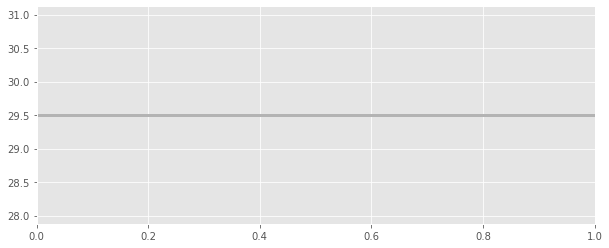

In [20]:
ylabel_dict = {'TP': 'TP (mg/l)',
               'chla': 'Chl-a (mg/l)',
               'colour': 'Colour (mg Pt/l)',
               'cyano': 'Cyanobacterial biovolume (mm$^3$/l)'}

# Loop over vars
for idx, var in enumerate(var_list):

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)

    # Add WFD boundary
    ax.axhline(y=boundaries_dict[var], color='0.7', lw=3)

    # Extract data

    # Forecasted
    if var != 'chla':
        forecasted = df_cont.loc[df_cont['node'] == var, ['sim_era5_av', 'year']]
    else:
        forecasted = df_cont.loc[df_cont['node'] == var, ['sim_naive', 'year']]
    forecasted = forecasted.set_index('year')

    # Observed
    obs = df_cont.loc[df_cont['node'] == var, ['obs', 'year']]
    obs = obs.set_index('year')

    # Plot forecast
    ax.plot(forecasted.index,
            forecasted.values,
            color='r',
            lw=1,
            label='Forecast')

    # Plot observations
    ax.plot(obs.index,
            obs.values,
            color='k',
            lw=1,
            label='Observed')

    # Tidy
    ax.set_ylabel(ylabel_dict[var])
    ax.set_xlim(xmin=1980, xmax=2020)
    ax.legend()

    plt.savefig(os.path.join(out_folder, 'Timeseries_gof', 'timeseries_operationalModel_%s.png' %var), dpi=150)